In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import datasets
import matplotlib.ticker as mtick
import random
%matplotlib inline

def get_train_and_test_classes(ds):
    if ds == 'cifar10':
        train_set = datasets.CIFAR10(root='/tmp', train=True, download=True);
        test_set  = datasets.CIFAR10(root='/tmp', train=False, download=True);
        train_classes = train_set.targets
        test_classes  = test_set.targets
    elif ds == 'svhn':
        train_set = datasets.SVHN(root='/tmp', split='train', download=True);
        test_set  = datasets.SVHN(root='/tmp', split='test', download=True);
        train_classes = train_set.labels
        test_classes  = test_set.labels
    return (train_classes, test_classes)

def sort_inf_by_classes(ds, train_mask, data_type, inf):
    train_classes, test_classes = get_train_and_test_classes(ds)
    
    argsorted_train_classes = np.argsort(np.array(train_classes)[train_mask])
    argsorted_test_classes  = np.argsort(np.array(test_classes))
    
    inf = inf[:, argsorted_train_classes]
    if data_type == 'train':
        inf = inf[argsorted_train_classes, :]
    elif data_type == 'test':
        inf = inf[argsorted_test_classes, :]
        
    return inf

def plot_ax(ax, inf, ds, title, data_type, axs_idx):
    ds_to_t = {'cifar10': {'train': 0.00001, 'test': 0.00001}, 
               'svhn':    {'train': 0.001,   'test': 0.0005}}
    t = ds_to_t[ds][data_type]
    ax.imshow(inf/np.linalg.norm(inf), cmap='binary', interpolation='bilinear', vmin=-t, vmax=t, 
              aspect=inf.shape[1]/inf.shape[0], extent=[0,inf.shape[1] ,0,inf.shape[0] ])
#     if axs_idx == 3:
#         plt.colorbar(im)
    # ax.set_title(title)
    if axs_idx%2 != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    if axs_idx%2 == 0:
        ax.set_ylabel(f'{data_type.capitalize()} image index', fontsize=axis_fontsize)
        
def pick_10():
    picked_idx = {}

    test_set  = datasets.CIFAR10(root='/tmp', train=False, download=True);

    shuffled_idx = list(range(len(test_set)))
    random.shuffle(shuffled_idx)
    i = 0
    while len(picked_idx) < 10:
        idx = shuffled_idx[i]
        picked_idx[test_set.targets[idx]] = idx
        i += 1
        
    return picked_idx

def remove_ticks(ax):
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

In [2]:
b           = 1
ds          = 'cifar10'
ub          = 3
num_images  = 3200
seed        = 1000000

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


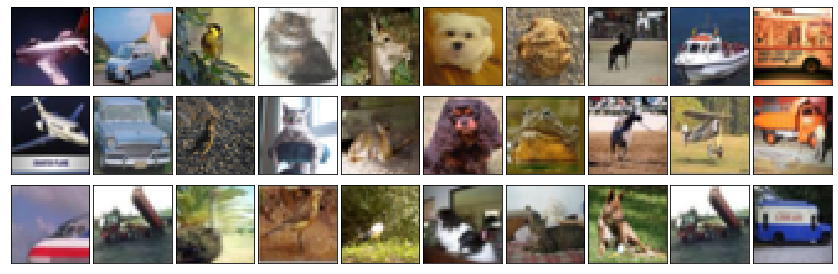

In [10]:
train_set = datasets.CIFAR10(root='/tmp', train=True, download=True);
test_set  = datasets.CIFAR10(root='/tmp', train=False, download=True);

train_mask = np.load(f'mask/{ds}_{num_images}_num_images_{seed}_seed.npy')

axis_fontsize = 12
right = 2
bottom = .1
top = 1
wspace = .05

fig = plt.figure(constrained_layout=False)

spec = fig.add_gridspec(ncols=10, nrows=3, left=0.1, right=right, bottom=bottom, top=top,
                         wspace=wspace, hspace=.1)

picked_idx = pick_10()

for i in range(10):
    ax = fig.add_subplot(spec[0,i])
    ax.imshow(test_set.data[picked_idx[i]])
    remove_ticks(ax)

data_type = 'test'
    
eps = 3
inf = np.load(f'influences/{ds}_target_{ub}_ub_{eps}_eps_{num_images}_images_{b}_batch_size_{data_type}.npy')[:10000, :]

    
for i in range(10):
    ax = fig.add_subplot(spec[1,i])
    argmax = np.argmax(inf[picked_idx[i]])
    ax.imshow(train_set.data[train_mask][argmax])
    remove_ticks(ax)
    
eps = 0
inf = np.load(f'influences/{ds}_target_{ub}_ub_{eps}_eps_{num_images}_images_{b}_batch_size_{data_type}.npy')

    
for i in range(10):
    ax = fig.add_subplot(spec[2,i])
    argmax = np.argmax(inf[picked_idx[i]])
    ax.imshow(train_set.data[train_mask][argmax])
    remove_ticks(ax)
    
fig.savefig(f'examples.pdf', dpi=200, bbox_inches='tight');

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


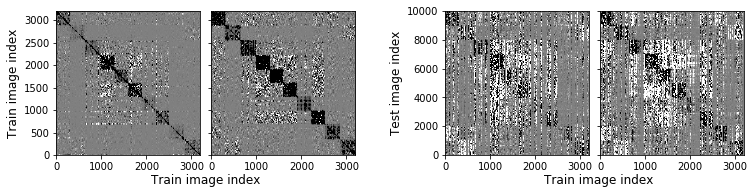

In [112]:
eps_to_infs = {}


data_type   = 'train'
for eps in [0,3]:
    train_mask = np.load(f'mask/{ds}_{num_images}_num_images_{seed}_seed.npy')
    inf = np.load(f'influences/{ds}_target_{ub}_ub_{eps}_eps_{num_images}_images_{b}_batch_size_{data_type}.npy')
    eps_to_infs[eps] = sort_inf_by_classes(ds, train_mask, data_type, inf)

# fig, axs = plt.subplots(1, 4, figsize=(14,3.5))

axis_fontsize = 12
right = .8
bottom = .1
top = .6
wspace = .05

fig = plt.figure(constrained_layout=False)

spec1 = fig.add_gridspec(ncols=2, nrows=1, left=0.1, right=right, bottom=bottom, top=top,
                         wspace=wspace, hspace=.1)

plot_ax(fig.add_subplot(spec1[0,0]), eps_to_infs[0], ds, 'Natural', data_type, 0)
plot_ax(fig.add_subplot(spec1[1]), eps_to_infs[3], ds, 'Robust', data_type, 1)

data_type   = 'test'
for eps in [0,3]:
    train_mask = np.load(f'mask/{ds}_{num_images}_num_images_{seed}_seed.npy')
    inf = np.load(f'influences/{ds}_target_{ub}_ub_{eps}_eps_{num_images}_images_{b}_batch_size_{data_type}.npy')
    eps_to_infs[eps] = sort_inf_by_classes(ds, train_mask, data_type, inf)

left = right+.2
spec2 = fig.add_gridspec(ncols=2, nrows=1, left=left, right=left+.7, bottom=bottom, top=top,
                     wspace=wspace, hspace=.1)
plot_ax(fig.add_subplot(spec2[0]), eps_to_infs[0], ds, 'Natural', data_type, 2)
plot_ax(fig.add_subplot(spec2[1]), eps_to_infs[3], ds, 'Robust', data_type, 3)

fig.text(0.45, 0.00, 'Train image index', ha='center', fontsize=axis_fontsize)
fig.text(1.36, 0.00, 'Train image index', ha='center', fontsize=axis_fontsize)

fig.savefig(f'influence_value.pdf', dpi=200, bbox_inches='tight');

In [3]:
from itertools import product

ds = 'cifar10'
eps = 3
data_type = 'test'
b = 1
num_images  = 3200
ub = 3
seed        = 1000000
tops = [100, 20]

plot_dict = {}

for eps, data_type, top_x in product([0, 3], ['train', 'test'], tops):

    train_classes, test_classes = get_train_and_test_classes(ds)
    train_mask = np.load(f'mask/{ds}_{num_images}_num_images_{seed}_seed.npy')

    train_classes = np.array(train_classes)[train_mask]

    inf = np.load(f'influences/{ds}_target_{ub}_ub_{eps}_eps_{num_images}_images_{b}_batch_size_{data_type}.npy')
    lim = 10000
    if data_type == 'train': 
        test_classes = train_classes
        lim = 3200
    inf = inf[:lim]
    test_classes = test_classes[:lim]
    
    argsorted_influence_matrix = np.argsort(-inf, axis=1)
    classes_matrix = np.tile(train_classes, (argsorted_influence_matrix.shape[0], 1))
    test_classes = np.array(test_classes)
    res = np.equal(test_classes, classes_matrix.T).T
    res = res[np.arange(argsorted_influence_matrix.shape[0])[:, None], argsorted_influence_matrix]
    res = res[:, :top_x]
    
    plot_dict[(eps, data_type, top_x)] = res

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


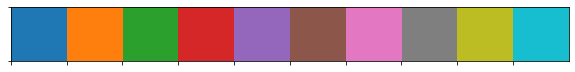

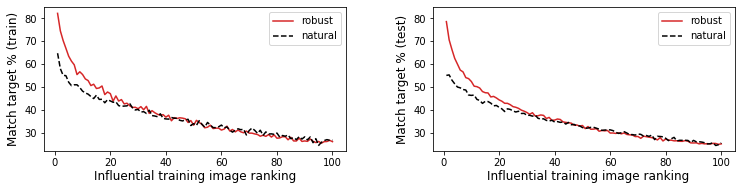

In [19]:
import seaborn as sns

current_palette = sns.color_palette()
sns.palplot(current_palette)

axis_fontsize = 12
right = .8
bottom = .1
top = .6
wspace = .05

fig = plt.figure(constrained_layout=False)

spec1 = fig.add_gridspec(ncols=2, nrows=1, left=0.1, right=right, bottom=bottom, top=top,
                         wspace=wspace, hspace=.1)

ax = fig.add_subplot(spec1[:])

nat = (np.sum(plot_dict[(0, 'train', 100)], axis=0)/3200)*100
rob = (np.sum(plot_dict[(3, 'train', 100)], axis=0)/3200)*100

ax.plot(list(range(1,101)), rob, label='robust', color=current_palette[3])
ax.plot(list(range(1,101)), nat, label='natural', linestyle='--', color='black')

ax.legend()
ax.set_ylabel('Match target % (train)', fontsize=axis_fontsize)
ax.set_ylim((22, 85))

left = right+.2
spec2 = fig.add_gridspec(ncols=2, nrows=1, left=left, right=left+.7, bottom=bottom, top=top,
                     wspace=wspace, hspace=.1)

ax = fig.add_subplot(spec2[:])

nat = (np.sum(plot_dict[(0, 'test', 100)], axis=0)/10000)*100
rob = (np.sum(plot_dict[(3, 'test', 100)], axis=0)/10000)*100

ax.plot(list(range(1,101)), rob, label='robust', color=current_palette[3])
ax.plot(list(range(1,101)), nat, label='natural', linestyle='--', color='black')

ax.legend()
ax.set_ylabel('Match target % (test)', fontsize=axis_fontsize)
ax.set_ylim((22,85))

fig.text(0.45, 0.00, 'Influential training image ranking', ha='center', fontsize=axis_fontsize)
fig.text(1.36, 0.00, 'Influential training image ranking', ha='center', fontsize=axis_fontsize)

fig.savefig(f'influence_top.pdf', dpi=200, bbox_inches='tight');

In [110]:
print(f'robust top-1: {rob[0]}')
print(f'natural top-1: {nat[0]}')

print(f"robust at least 3 out of 5: {100*np.sum(np.sum(plot_dict[(3, 'test', 100)][:, :5], axis=1)>=3)/10000}")
print(f"natural at least 3 out of 5: {100*np.sum(np.sum(plot_dict[(0, 'test', 100)][:, :5], axis=1)>=3)/10000}")

robust top-1: 78.61
natural top-1: 55.08
robust at least 3 out of 5: 77.33
natural at least 3 out of 5: 53.79
